In [1]:
import uproot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sys
import h5py

In [3]:
sys.path.append('/project/rpp-blairt2k/jgao/WatChMaL')
import analysis.event_utils as ev

In [4]:
# list of particle names to use in filename
# particle_names = ['gamma', 'e-', 'mu-', 'pi0'] # note that the order corresponds to labels 0, 1, 2, 3
particle_names = ['e-', 'mu-', 'pi0']

# Preparing data

## Get true particle data from h5 file

In [5]:
# get indices of test events
idxs_path = '/scratch/jgao/data/HKHybrid/idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs  = idxs['test_idxs']

In [6]:
# open h5 file and get data for test events
data_path = "/scratch/jgao/data/HKHybrid/all.hdf5"
h5_file = h5py.File(data_path, "r")
h5_angles     = np.array(h5_file['angles'])[test_idxs].squeeze()
h5_energies   = np.array(h5_file['energies'])[test_idxs].squeeze()
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()
h5_root_files = np.array(h5_file['root_files'])[test_idxs].squeeze()
h5_event_ids  = np.array(h5_file['event_ids'])[test_idxs].squeeze()
h5_vetos      = np.array(h5_file['veto'])[test_idxs].squeeze()

## Get fiTQun data from files

In [7]:
# create dictionaries to fill with fitqun data for each particle type
flag_e = {}
flag_mu = {}
flag_pi0 = {}
e_nll = {}
mu_nll = {}
pi0_nll = {}
reco_mom_e = {}
reco_mom_mu = {}
reco_mom_pi0 = {}
reco_pos_e = {}
reco_dir_e = {}
pi0mass = {}
particles = {}
totq = {}

In [8]:
# get the data from the fitqun files
fq_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/"
for p in particle_names:
    # open the fiTQun TTree from the file with uproot
    fq = uproot.open(fq_path+f"HKHybrid_{p}_3000x400.fiTQun.root")['fiTQun']
    # extract each branch of the TTree fom the ROOT file into a numpy array, placed in the dictionaries
    flag_e[p] = np.array(fq['fq1rpcflg'].array()[:,0,1])
    flag_mu[p] = np.array(fq['fq1rpcflg'].array()[:,0,2])
    flag_pi0[p] = np.array(fq['fqpi0pcflg'].array()[:,0])
    e_nll[p] = np.array(fq['fq1rnll'].array()[:,0,1])
    mu_nll[p] = np.array(fq['fq1rnll'].array()[:,0,2])
    pi0_nll[p] = np.array(fq['fqpi0nll'].array()[:,0])
    reco_mom_e[p] = np.array(fq['fq1rmom'].array()[:,0,1])
    reco_mom_mu[p] = np.array(fq['fq1rmom'].array()[:,0,2])
    reco_mom_pi0[p] = np.array(fq['fqpi0momtot'].array()[:,0])
    reco_pos_e[p] = np.array(fq['fq1rpos'].array()[:,0,1,:])
    reco_dir_e[p] = np.array(fq['fq1rdir'].array()[:,0,1,:])
    pi0mass[p] = np.array(fq['fqpi0mass'].array()[:,0])
    totq[p] = np.array(fq['fqtotq'].array()[:,0])
    # the labels are just 0, 1, 2, or 3 based on which particle it is, repeated for the number of events
    particles[p] = np.repeat(particle_names.index(p), fq.num_entries)

In [9]:
# create arrays stacking together the particles
# the order of the particles in the test set of the h5 file is [e-, mu-, gamma, pi0]
# particle_order = [particle_names[i] for i in h5_labels[::1200000]] #['e-', 'mu-']
particle_order = ['e-', 'mu-', 'pi0']
fq_flag_e = np.concatenate([flag_e[i] for i in particle_order])
fq_flag_mu = np.concatenate([flag_mu[i] for i in particle_order])
# fq_flag_pi0 = np.concatenate([flag_pi0[i] for i in particle_order])
fq_e_nll = np.concatenate([e_nll[i] for i in particle_order])
fq_mu_nll = np.concatenate([mu_nll[i] for i in particle_order])
# fq_pi0_nll = np.concatenate([pi0_nll[i] for i in particle_order])
fq_reco_mom_e = np.concatenate([reco_mom_e[i] for i in particle_order])
fq_reco_mom_mu = np.concatenate([reco_mom_mu[i] for i in particle_order])
# fq_reco_mom_pi0 = np.concatenate([reco_mom_pi0[i] for i in particle_order])
fq_reco_pos_e = np.concatenate([reco_pos_e[i] for i in particle_order])
fq_reco_dir_e = np.concatenate([reco_dir_e[i] for i in particle_order])
# fq_pi0mass = np.concatenate([pi0mass[i] for i in particle_order])
fq_particles = np.concatenate([particles[i] for i in particle_order])
fq_totq = np.concatenate([totq[i] for i in particle_order])

# No need for the following part as there are as many test events as fq recon events
## Find the fiTQun events corresponding to the test set
For the IWCD mPMT e/mu/gamma/pi0 data, there are events missing from the h5 digihits file (used for training and testing) that are not missing from the fiTQun set, so we need to find how to match them up properly. We use the following to match them up:
- Each event in the h5 file has a `label` (particle type), a `root_file` and a `event_id`
- The events in the h5 file are ordered by `label` then `root_file` then `event_id`
- The fiTQun files have all events for one particle type, ordered by `root_file`, then by `event_id`
- Each `root_file` originally has exactly 3000 events in the fiTQun file
- The `event_id`s in for each root file in the fiTQun file go consecutively from 0 to 2999
- The h5 file has a subset of the events in the fiTQun files, and has at least one event from every `root_file`

So we loop through the h5 file events, check the `label` to find which particle it is to choose the corresponding fitqun file, check the `root_file`, if it's the same as the previous then we compare to previous `event_id` and if there's a jump then we skip [new `event_id` minus old `event_id`+1] events in the fiTQun files. If it's a new `root_file` then we skip [new `event_id` plus 3000 minus old `event_id`+1].

Or, we do it more efficiently by adding up offsets by particle type, root file and event_id, because we know:
- There are 400 `root_files` included in the test set for each particle
- There are 3000 `event_id`s running from 0 to 2999 for each `root_file`
So, if we index the `root_files` from 0 to 399 for particle 0, 400 to 799 for particle 1, and so on, then the offset is just `3000*[root_file_index] + [event_id]`

In [33]:
# create dictionary with keys of the unique root_files
root_file_index = dict.fromkeys(h5_root_files)
# update the values to be ascending order
root_file_index.update((k, i) for i, k in enumerate(root_file_index))

In [35]:
root_file_indices = np.vectorize(root_file_index.__getitem__)(h5_root_files)
# h5_fq_offsets = 3000*root_file_indices + h5_event_ids

In [11]:
# selection of events for h5
# fq used first 600 events in the 400 test files for each particle type
h5_fq_offsets = np.array([(evt+3000*file) for file in range(400) for evt in range(0,600)])  # for e- alone
h5_fq_offsets = np.append(h5_fq_offsets, h5_fq_offsets+1200000)
np.savez("h5_fq_offsets.npz", h5_fq_offsets=h5_fq_offsets)

In [9]:
h5_fq_offsets_data = np.load("./h5_fq_offsets.npz", allow_pickle=True)
h5_fq_offsets      = h5_fq_offsets_data['h5_fq_offsets']

In [11]:
# IWCD only
# h5_flag_e = fq_flag_e[h5_fq_offsets]
# h5_flag_mu = fq_flag_mu[h5_fq_offsets]
# h5_flag_pi0 = fq_flag_pi0[h5_fq_offsets]
# h5_e_nll = fq_e_nll[h5_fq_offsets]
# h5_mu_nll = fq_mu_nll[h5_fq_offsets]
# h5_pi0_nll = fq_pi0_nll[h5_fq_offsets]
# h5_reco_mom_e = fq_reco_mom_e[h5_fq_offsets]
# h5_reco_mom_mu = fq_reco_mom_mu[h5_fq_offsets]
# h5_reco_mom_pi0 = fq_reco_mom_pi0[h5_fq_offsets]
# h5_reco_pos_e = fq_reco_pos_e[h5_fq_offsets]
# h5_reco_dir_e = fq_reco_dir_e[h5_fq_offsets]
# h5_pi0mass = fq_pi0mass[h5_fq_offsets]
# h5_particles = fq_particles[h5_fq_offsets]
# h5_totq = fq_totq[h5_fq_offsets]

In [10]:
h5_angles_cut     = h5_angles[h5_fq_offsets]
h5_energies_cut   = h5_energies[h5_fq_offsets]
h5_positions_cut  = h5_positions[h5_fq_offsets]
h5_labels_cut     = h5_labels[h5_fq_offsets]
h5_root_files_cut = h5_root_files[h5_fq_offsets]
h5_event_ids_cut  = h5_event_ids[h5_fq_offsets]
h5_vetos_cut      = h5_vetos[h5_fq_offsets]

## ---------------------------------------

Text(0.5, 1.0, 'E-')

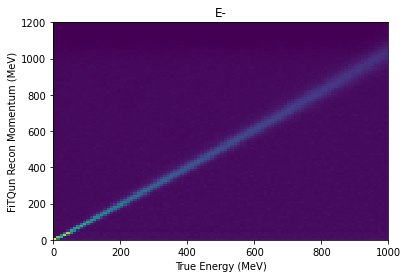

In [16]:
# check e- seem to be matched right, should be roughly diagonal fitqun momentum vs true energy
p = plt.hist2d(h5_energies[h5_labels==1], fq_reco_mom_e[h5_labels==1], bins=100, range=[[0,1000],[0,1200]])
plt.xlabel("True Energy (MeV)")
plt.ylabel("FiTQun Recon Momentum (MeV)")
plt.title("E-")

Text(0.5, 1.0, 'Mu-')

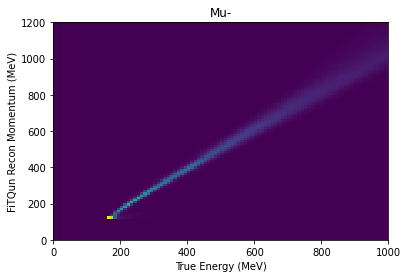

In [17]:
# check muons
p = plt.hist2d(h5_energies[h5_labels==2], fq_reco_mom_mu[h5_labels==2], bins=100, range=[[0,1000],[0,1200]])
plt.xlabel("True Energy (MeV)")
plt.ylabel("FiTQun Recon Momentum (MeV)")
plt.title("Mu-")

Text(0.5, 1.0, 'Pi0')

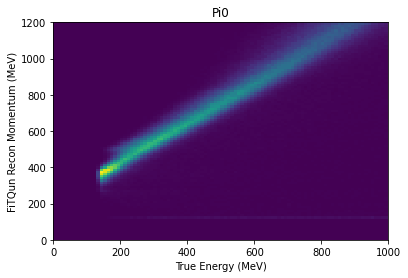

In [18]:
# check pi0
p = plt.hist2d(h5_energies[h5_labels==3], fq_reco_mom_mu[h5_labels==3], bins=100, range=[[0,1000],[0,1200]])
plt.xlabel("True Energy (MeV)")
plt.ylabel("FiTQun Recon Momentum (MeV)")
plt.title("Pi0")

# Plotting fiTQun and ResNet performance

## Load ResNet results

In [105]:
# load softmaxes
softmaxes = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-08-11/05-48-21/outputs/softmax.npy')
indices = np.load('/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-08-11/05-48-21/outputs/indices.npy')
# reorder them by the indices, to get same order as the h5 file
softmaxes[indices] = np.copy(softmaxes)

(2400000, 3)


## Set up plotting style

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 28}
matplotlib.rc('font', **font)

## Make some cuts to select the events of interest

In [13]:
# need to overwrite the tank_half_height and tank_radius parameters that towall and dwall funcs takes in
# The length unit is mm and the the lengths are the dimentions of the ID, so HK ID tank is 32.4m (?) in radius
# and 65.8 m (?) in height. Note the half height is 32.9 m.
towall = ev.towall(h5_positions_cut, h5_angles_cut, tank_half_height=3290, tank_radius=3240, tank_axis=2)
dwall = ev.dwall(h5_positions_cut, tank_half_height=3290, tank_radius=3240, tank_axis=2)
momentum = ev.momentum(h5_energies_cut, h5_labels_cut)

[4071026.10734686 1203268.05920122 3693644.69397062 ... 7562817.67796177
 5655560.91485503 2827122.98611289]


/home/jgao/work/WatChMaL/analysis/event_utils.py:31: RuntimeWarning: invalid value encountered in sqrt
  towall_barrel = (-b + np.sqrt(b**2-a*c)) / (a)


In [14]:
towall_cut = towall > 0.63*np.log(momentum) # only for electrons
dwall_cut = dwall > 2
reco_cut = (fq_flag_e == 0) & (fq_flag_mu == 0)
od_veto_cut = (h5_vetos_cut == 0)

# select the true electron events that pass the cuts
electrons = (h5_labels_cut==1) & towall_cut & dwall_cut & reco_cut #& od_veto_cut
# select the true muon events that pass the cuts
muons = (h5_labels_cut==2)  & towall_cut & dwall_cut & reco_cut #& od_veto_cut

## electron efficiency for fixed 0.5% muon mis-ID

### for each 50 MeV bin of reconstructed momentum, calculate the thresholds for fiTQun

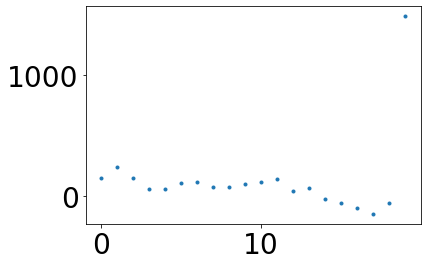

In [137]:
# the electron-like discriminator is the negative log-likelihood difference
emu_nll = fq_mu_nll - fq_e_nll

# set up the bins
bin_low = 0
bin_high = 1000
bin_width = 50
bin_lows = np.arange(bin_low, bin_high, bin_width)

# for each particle type, for each bin, make a boolean array to say whether each event belongs in that bin
e_bin_selections = [
    (fq_reco_mom_e[electrons] > l) & (fq_reco_mom_e[electrons] <= l+bin_width)
    for l in bin_lows
]
mu_bin_selections = [
    (fq_reco_mom_e[muons] > l) & (fq_reco_mom_e[muons] <= l+bin_width)
    for l in bin_lows
]

# for each bin, the threshold that gives 0.5% mis-ID (99.5% are below the threshold)
fq_thresholds = [np.quantile(emu_nll[muons][c], 0.995) for c in mu_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
fq_electron_truepositives = np.zeros_like(emu_nll[electrons]).astype(bool)
fq_muon_falsepositives = np.zeros_like(emu_nll[muons]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(fq_thresholds, e_bin_selections):
    fq_electron_truepositives[c] = emu_nll[electrons][c] > t
for t, c in zip(fq_thresholds, mu_bin_selections):
    fq_muon_falsepositives[c] = emu_nll[muons][c] > t

### calculate the thresholds for PointNet

20 [5.411480712320953e-12, 2.990861369331355e-12, 3.5108263084920876e-12, 1.1559840834129279e-12, 4.628167426124627e-12, 2.123342551590101e-12, 5.864910033320793e-12, 2.342351846339185e-12, 1.6559421639906358e-12, 3.99681386077655e-12, 4.4134532833917116e-12, 2.366460183193809e-12, 2.487739110849582e-12, 8.150952785987435e-13, 2.4825614979538665e-12, 4.151064179891417e-12, 4.815135048498454e-12, 4.891197006879482e-13, 6.090874110414523e-13, 1.6956094579627378e-12]


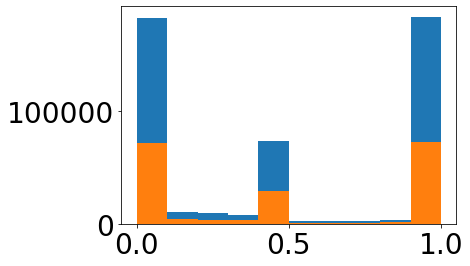

In [148]:
# the electron-like discriminator is 1-[muon softmax] 
elike_softmax = (1-softmaxes[:,2])[h5_fq_offsets]

# for each bin, the threshold that gives 0.5% mis-ID (99.5% are below the threshold)
# pointnet_thresholds = [np.quantile(elike_softmax[electrons][c], 0.005) for c in e_bin_selections]

resnet_thresholds = [np.quantile(elike_softmax[muons][c], 0.995) for c in mu_bin_selections]

# for each particle type, for each bin, make a, boolean array to say whether each event is below the threshold
# start by filling it full of false
resnet_electron_truepositives = np.zeros_like(elike_softmax[electrons]).astype(bool)
resnet_muon_falsepositives = np.zeros_like(elike_softmax[muons]).astype(bool)
# then loop over the bins and set to true for the events in those bins that are over the threshold
for t, c in zip(resnet_thresholds, e_bin_selections):
    resnet_electron_truepositives[c] = elike_softmax[electrons][c] < t
for t, c in zip(resnet_thresholds, mu_bin_selections):
    resnet_muon_falsepositives[c] = elike_softmax[muons][c] < t

### Plot against true momentum

193636


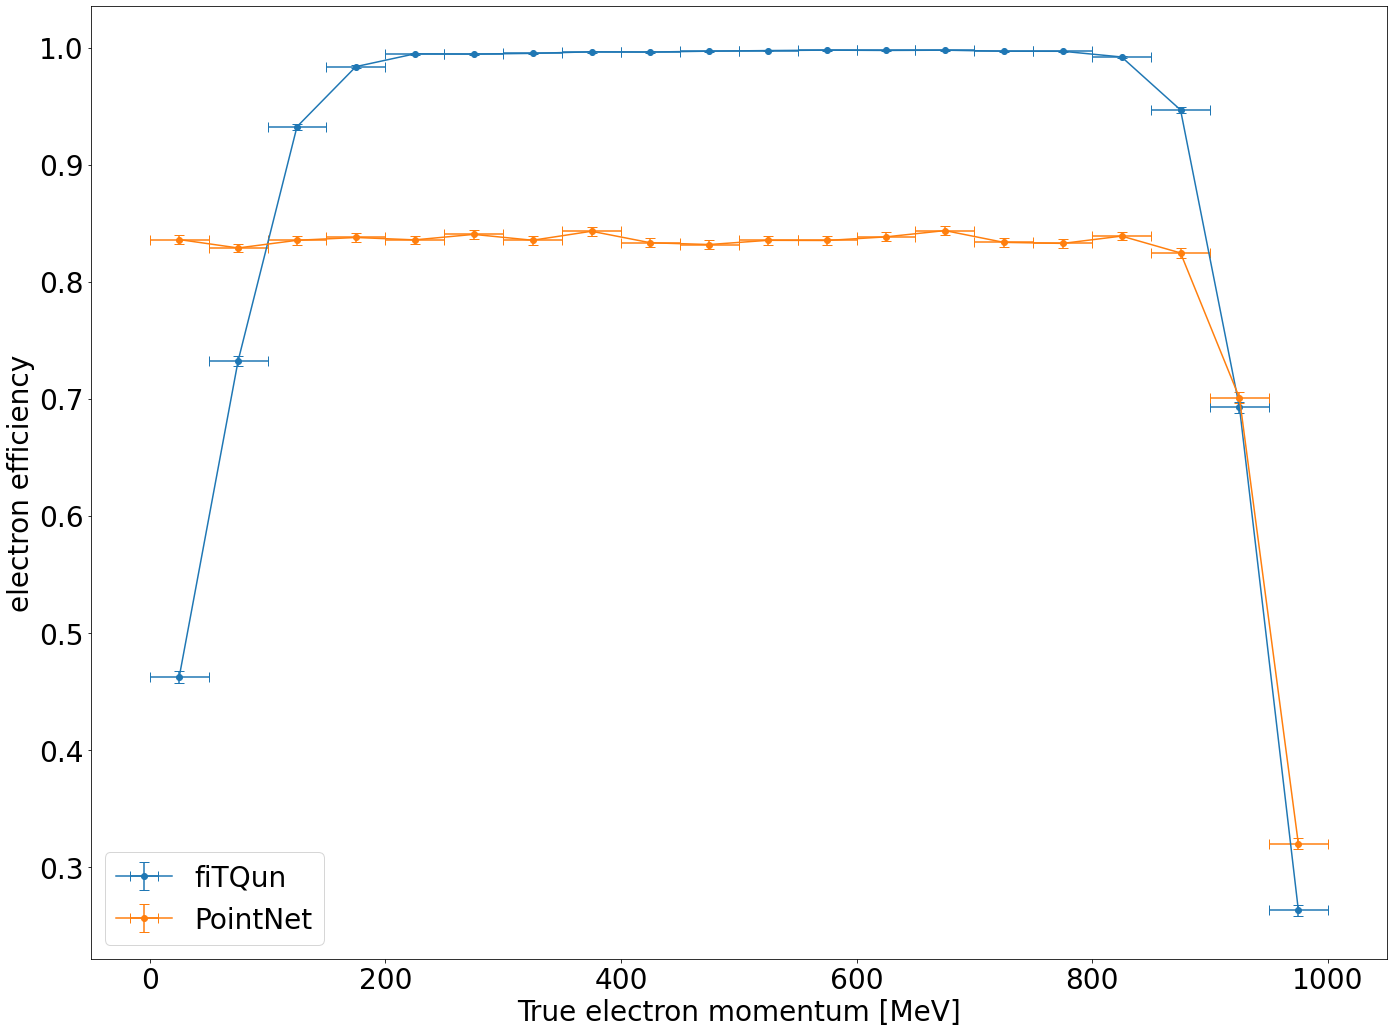

In [150]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = 1000
plot_bin_width = 50
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (momentum[electrons] > l) & (momentum[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
fq_eff_binned = np.array([np.mean(fq_electron_truepositives[c]) for c in plot_bin_selections])
fq_eff_binned_err = np.sqrt(fq_eff_binned*(1-fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
resnet_eff_binned = np.array([np.mean(resnet_electron_truepositives[c]) for c in plot_bin_selections])
resnet_eff_binned_err = np.sqrt(resnet_eff_binned*(1-resnet_eff_binned)/np.sum(plot_bin_selections, axis=1))

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, fq_eff_binned, yerr=fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='fiTQun', fmt='-o', capsize=5)
ax.errorbar(plot_bin_centres, resnet_eff_binned, yerr=resnet_eff_binned_err, xerr=plot_bin_halfwidths,
            label='PointNet', fmt='-o', capsize=5)
ax.set_xlabel("True electron momentum [MeV]")
ax.set_ylabel("electron efficiency")
ax.legend()
fig.tight_layout()

### Plot against zenith

In [143]:
zenith = h5_angles_cut[:,0]

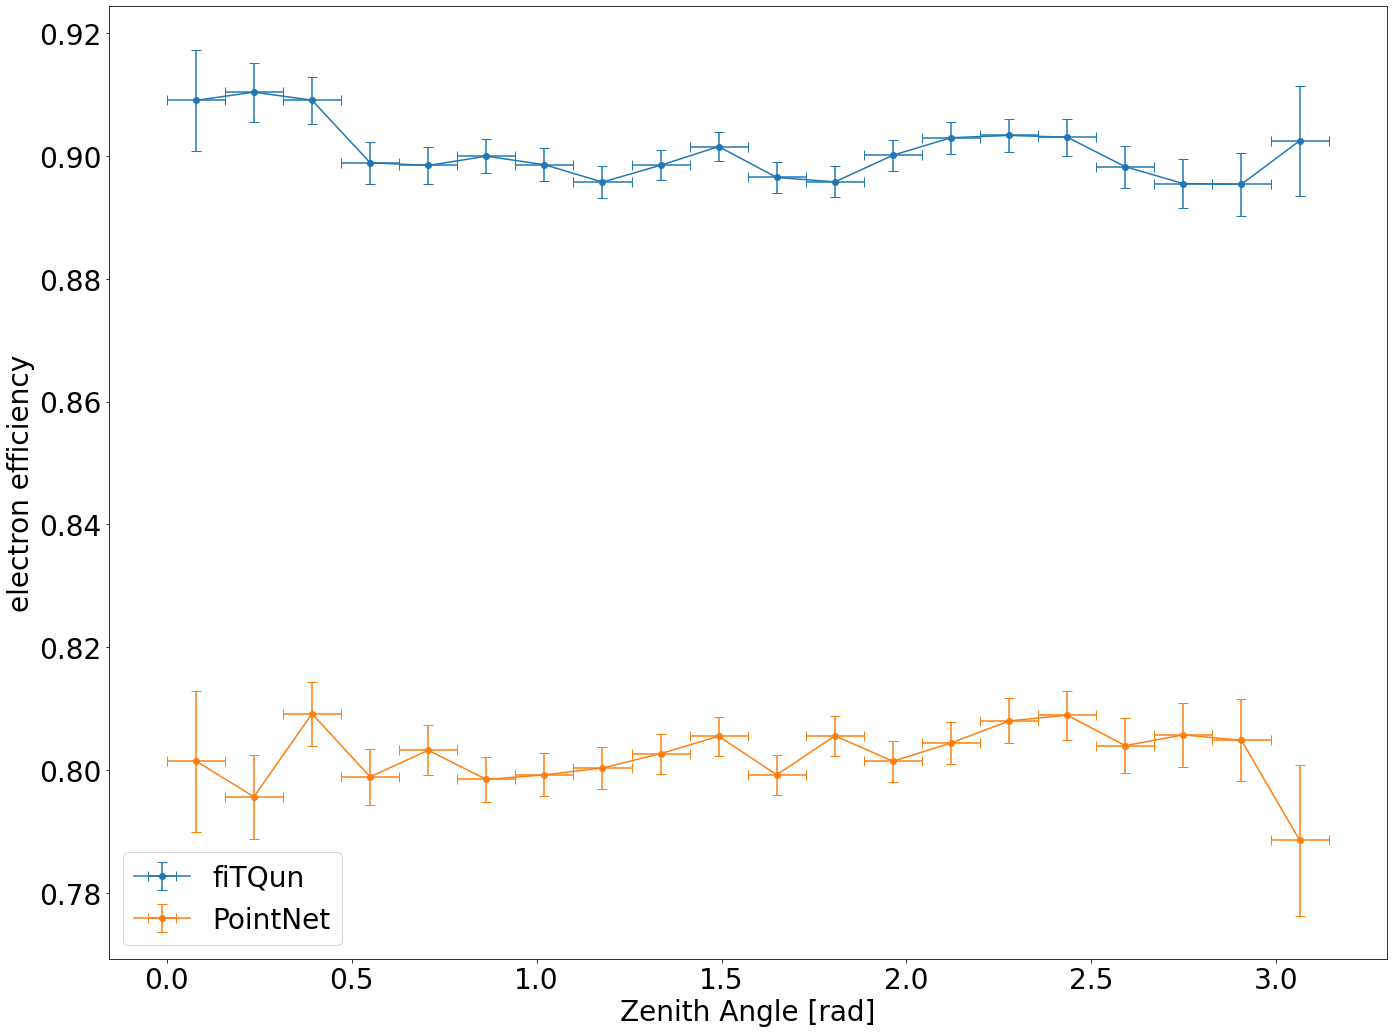

In [149]:
# define the bins for the plot
plot_bin_low = 0
plot_bin_high = np.pi
plot_bin_width = np.pi/20
plot_bin_lows = np.arange(plot_bin_low, plot_bin_high, plot_bin_width)
plot_bin_centres = np.arange(plot_bin_low + plot_bin_width/2, plot_bin_high, plot_bin_width)
plot_bin_halfwidths = np.full_like(plot_bin_centres, plot_bin_width/2)

# for each particle, each bin, find the events in that bin
plot_bin_selections = [
    (zenith[electrons] > l) & (zenith[electrons] <= l+plot_bin_width)
    for l in plot_bin_lows
]

# for each particle, for each bin, calculate the efficiency rate and the error bar
# for fiTQun
fq_eff_binned = np.array([np.mean(fq_electron_truepositives[c]) for c in plot_bin_selections])
fq_eff_binned_err = np.sqrt(fq_eff_binned*(1-fq_eff_binned)/np.sum(plot_bin_selections, axis=1))
# for ResNet
resnet_eff_binned = np.array([np.mean(resnet_electron_truepositives[c]) for c in plot_bin_selections])
resnet_eff_binned_err = np.sqrt(resnet_eff_binned*(1-resnet_eff_binned)/np.sum(plot_bin_selections, axis=1))

# plot the results
fig, ax = plt.subplots(figsize=(20,15))
ax.errorbar(plot_bin_centres, fq_eff_binned, yerr=fq_eff_binned_err, xerr=plot_bin_halfwidths,
            label='fiTQun', fmt='-o', capsize=5)
ax.errorbar(plot_bin_centres, resnet_eff_binned, yerr=resnet_eff_binned_err, xerr=plot_bin_halfwidths,
            label='PointNet', fmt='-o', capsize=5)
ax.set_xlabel("Zenith Angle [rad]")
ax.set_ylabel("electron efficiency")
ax.legend()
fig.tight_layout()